# Group 10 - First Year Project
### Data Science at ITU 
## Project 2 - Correlation between Covid-19's spread and weather conditions

Introduction

This notebook contains all the code developed in the Project 2 - Correlation between Covid-19's spread and weather conditions

Contact/Group: 
- Florian Micliuc(flmi@itu.dk)
- Louis Caspar Brandt (locb@itu.dk)
- Iben Mai Huse (ibhu@itu.dk)
- Katalin Literati-Dobos (klit@itu.dk)
- Ruben Jonsman (rubj@itu.dk)

#  Library imports

In [58]:
import numpy as np
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
import math
from collections import Counter
from scipy.stats import chi2_contingency
import seaborn as sns
import folium
from folium import plugins 
from folium.plugins import HeatMap, MarkerCluster
import shapely
import json 
from shapely.geometry import Point, MultiPoint, LineString, MultiLineString, Polygon, MultiPolygon
import branca
import branca.colormap as cm
import statsmodels.api as sm
from scipy.stats import pearsonr, spearmanr
from folium.features import DivIcon
import imageio
from matplotlib import rcParams
import calmap
import calplot

# Functions

In [2]:
def check_null_values(file, string):
    if file.isnull().values.any():
        print('There are null values in {} dataset'.format(string))
    else:
        print('There are no null values in {} dataset'.format(string))

In [3]:
def dataset_checker_values(dataset,value):
    SA = dataset.copy()
    SA.replace(value, np.nan, inplace=True)
    missingdata_df = SA.columns[SA.isnull().any()].tolist()
    msno.matrix(SA);

In [4]:
def weather_mean_bar_plot(column,df):
    list_month = ['February','March','April','May','June','July','August','September','October','November','December','January','February']
    fig,ax = plt.subplots(figsize = (16,4))
    df[column].plot.bar(color = 'silver',edgecolor = 'black',rot = 0)
    ax.set_title('Mean of' + ' '+ column)
    ax.set_ylabel('Value')
    ax.set_xlabel('Month')
    ax.set_xticklabels(list_month)

In [5]:
def corona_total_bar_plot(column,df):
    list_month = ['February','March','April','May','June','July','August','September','October','November','December','January','February']
    fig,ax = plt.subplots(figsize = (16,4))
    df[column].plot.bar(color = 'silver',edgecolor = 'black',rot = 0)
    ax.set_title(column)
    ax.set_ylabel('Value')
    ax.set_xlabel('Month')
    ax.set_xticklabels(list_month)

In [6]:
def corona_line_plot(df,x,y,title):
    ax = df.plot.line(x = x, y = y,rot = 45,figsize = (20,6),color = 'silver')
    ax.set_title(title)
    ax.set_ylabel("Covid-19 Cases")
    ax.set_xlabel("Date")
    plt.axvline(x='2020-03-15',color = '#ff6c70',ls = '--');
    plt.axvline(x='2020-03-22',color = '#f00008',ls = '--');
    plt.axvline(x='2020-04-15',color = 'blue',ls = '--');
    plt.axvline(x='2020-11-02',color = '#ff6c70',ls = '--');
    plt.axvline(x='2020-12-15',color = '#f00008',ls = '--');
    plt.axvline(x='2020-12-26',color = '#00ff68',ls = '--');

In [7]:
def corona_bar_plot(x,y,title):
    fig = plt.figure(figsize=(20,6))
    axes = fig.add_axes([0,0,1,1])
    axes.bar(x, y,color = 'silver',edgecolor = 'black')
    axes.set_title(title)
    axes.set_ylabel("Covid-19 Cases")
    axes.set_xlabel("Date")

In [8]:
def pearson_association(df,column,headers,significance):
    corrs = []
    pvalues = []
    for var in headers:
        corr, pvalue = pearsonr(df[column], df[var])
        print(var,'\n',round(corr,5),'   ',pvalue,pvalue<significance,'\n')

In [9]:
def spearman_association(df,column,headers,significance):
    corrs = []
    pvalues = []
    for var in headers:
        corr, pvalue = spearmanr(df[column], df[var])
        print(var,'\n',round(corr,5),'   ',pvalue,pvalue<significance,'\n')

In [10]:
def pearson_log(df,column,headers,significance):
    corrs = []
    pvalues = []
    for var in headers:
        corr, pvalue = pearsonr(np.log(df[column]), df[var])
        print(var,'\n',round(corr,5),'   ',pvalue,pvalue<significance,'\n')

In [51]:
def heat_calendar(df,column,color):
    calplot.calplot(df[column], cmap=color,colorbar = True,figsize = (16,4));

# Task 0 - Data cleaning and filtering

## Loading data

The data was loaded by creating a small pipeline to keep track of files and locations, in case they would change. This approach made it easy to change file locations if needed.

In [11]:
PATH = {}
PATH["data_raw"] = "../data/raw/"
PATH["data_interim"] = "../data/interim/"
PATH["data_processed"] = "../data/processed/"
PATH["data_external"] = "../data/external/"

SUBPATH = {}
SUBPATH["corona"] = "corona/"
SUBPATH["meta"] = "metadata/"
SUBPATH["shape"] = "shapefiles/"
SUBPATH["weather"] = "weather/"
SUBPATH["age"] = "age/"

FILENAME = {}
FILENAME["corona"] = "de_corona.csv"
FILENAME["meta"] = "de_metadata.json"
FILENAME["shape"] = "de.geojson"
FILENAME["weather"] = "weather.csv"
FILENAME["age_pop"] = "Altersverteilung_Bevolkerung.csv"

corona = PATH["data_raw"]+SUBPATH["corona"]+FILENAME["corona"]
meta = PATH["data_raw"]+SUBPATH["meta"]+FILENAME["meta"]
shape = PATH["data_raw"]+SUBPATH["shape"]+FILENAME["shape"]
weather = PATH["data_raw"]+SUBPATH["weather"]+FILENAME["weather"]
age_pop = PATH["data_external"]+SUBPATH["age"]+FILENAME["age_pop"]

The dates is parsed in the data, so that it has a consistent form. The data is tab seperated and thus we load the data with a tab seperator. We also append the extra data that was provided to our original weather data frame.

In [12]:
raw_data = {}

from datetime import datetime
dateparse = lambda x: datetime.strptime(x, '%Y-%m-%d')

raw_data['de_corona'] = pd.read_csv(corona, sep='\t', parse_dates=['date'], date_parser=dateparse)
raw_data['weather'] = pd.read_csv(weather, sep='\t', parse_dates=['date'], date_parser=dateparse)
additional = pd.read_csv('../Data/Raw/weather/weather2.csv', sep='\t', parse_dates=['date'], date_parser=dateparse)
raw_data['weather'] = raw_data['weather'].append(additional)

with open(meta, 'r', encoding='utf-8') as f:
    country_metadata = json.loads(f.read())

raw_data['age_pop'] = pd.read_csv(age_pop, sep=';', decimal=',')

In [13]:
HEADERS = ['de_corona','weather']
for i in HEADERS:
    print(i +"  \tDataFrame shape: " + str(raw_data[i].shape))

de_corona  	DataFrame shape: (5602, 4)
weather  	DataFrame shape: (20220, 9)


## Data type insight

With the data provided involved the following fields: 

In [14]:
list(raw_data["weather"].columns), list(raw_data["de_corona"].columns)

(['date',
  'iso3166-2',
  'RelativeHumiditySurface',
  'SolarRadiation',
  'Surfacepressure',
  'TemperatureAboveGround',
  'Totalprecipitation',
  'UVIndex',
  'WindSpeed'],
 ['date', 'region_code', 'confirmed_addition', 'deceased_addition'])

The following fields are categorical variables:
- iso3166-2 (the codes of the regions in Germany)
- date
- region_code (the name of the region)

The following fields are numerical variables:
- RelativeHumiditySurface 
- SolarRadiation
- Surfacepressure 
- TemperatureAboveGround (measured in Kelvin)
- Totalprecipitation
- UVIndex (1-10)
- Windspeed (m/s)
- confirmed_addition (number of confirmed Covid-19 infections)
- deceased_addition (number of deceased with a confirmed Covid-19 infections)

All the weather data is a 24-hour sum of the day, which will result in higher than expected values, these variables can be divided by 24 to get the mean of the day, though this will also be flawed data, since the data will have a daily mean. SolarRadiation, UVIndex is only relevent when the sun is actually present during the day, by getting the daily mean, the hours of the day where the sun is not active is taken into account, which results in lower than expected values. 

## Filtering the weather dataset

Our assigned country in this project is Germany and thus we filter the data so that we only have data from Germany

In [15]:
weather_data_de = raw_data["weather"][raw_data["weather"]["iso3166-2"].str.startswith("DE")]
weather_data_de.reset_index(drop=True, inplace=True)
processed_data = {}
processed_data["weather"] = weather_data_de
processed_data["weather"].to_csv("../Data/Processed/processed_weather.csv")
processed_data["de_corona"] = raw_data["de_corona"]

## Relational data table needed?
#Description

## Sanity check

Here we check for typical issues with raw data. We are checking for missing data, duplicate data and null values.

### Check for null values

In [16]:
check_null_values(raw_data['de_corona'], "de_corona")
check_null_values(weather_data_de, "weahter_data_de")

There are no null values in de_corona dataset
There are no null values in weahter_data_de dataset


### Checking and visualizing for weird values

In [17]:
#dataset_checker_values(weather_data_de,-999) #-999

In [18]:
#dataset_checker_values(weather_data_de,-1) #-1

In [19]:
#dataset_checker_values(raw_data['de_corona'],-999) #-999

In [20]:
#dataset_checker_values(raw_data['de_corona'],-1) #-1

### Checking for duplicates

In [21]:
if True in list(raw_data["de_corona"].duplicated()):
    print("Duplicate rows")
else: 
    print("No duplicate rows")

No duplicate rows


# Numerical summary

## Germany corona dataset

There are 16 regions

In [22]:
pd.Series(raw_data['de_corona']['region_code']).unique()

array(['Nordrhein-Westfalen', 'Berlin', 'Saarland', 'Bayern',
       'Niedersachsen', 'Mecklenburg-Vorpommern', 'Brandenburg',
       'Baden-Württemberg', 'Hessen', 'Rheinland-Pfalz',
       'Schleswig-Holstein', 'Hamburg', 'Bremen', 'Sachsen', 'Thüringen',
       'Sachsen-Anhalt'], dtype=object)

### Daily registered cases in Germany

In [23]:
raw_data["de_corona"].describe()

,confirmed_addition,deceased_addition
count,5602.000000,5602.000000
mean,426.786862,12.121028
std,831.095886,25.823844
min,1.000000,0.000000
25%,18.000000,0.000000
50%,95.000000,1.000000
75%,396.000000,10.000000
max,6809.000000,213.000000


In [24]:
rcParams['figure.figsize'] = 25,4;

C:\Users\flori\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


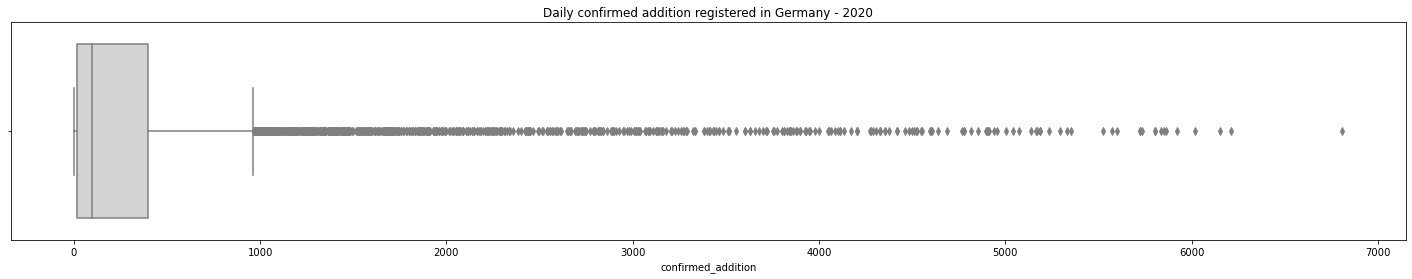

In [25]:
deCorona_confirmed = raw_data['de_corona']['confirmed_addition']
sns.boxplot(deCorona_confirmed, color='lightgray').set_title('Daily confirmed addition registered in Germany - 2020');

C:\Users\flori\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


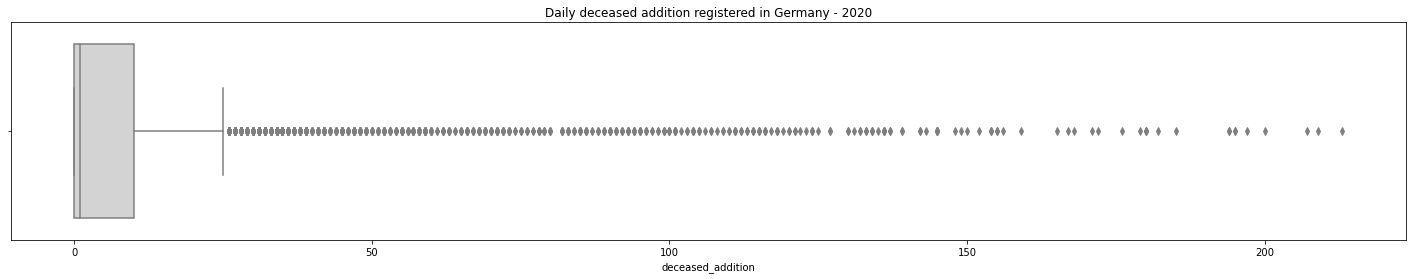

In [27]:
deCorona_deceased = raw_data['de_corona']['deceased_addition']
sns.boxplot(deCorona_deceased, color='lightgray').set_title('Daily deceased addition registered in Germany - 2020');

### 2020 - all registered cases in Germany

In [74]:
#### Region names with iso3166-2 codes and population - all cases
region_map = {country_metadata["country_metadata"][i]["covid_region_code"]: country_metadata["country_metadata"][i]["iso3166-2_code"] for i in range(len(country_metadata["country_metadata"]))}

raw_data["de_corona"]["region"] = raw_data["de_corona"]["region_code"].map(region_map)

corona_df_by_region = raw_data["de_corona"].groupby(by = "region")["confirmed_addition", "deceased_addition", ].sum().reset_index()

population_map = {country_metadata["country_metadata"][i]["iso3166-2_code"]: country_metadata["country_metadata"][i]["population"] for i in range(len(country_metadata["country_metadata"]))}

corona_df_by_region["population"] = corona_df_by_region["region"].map(population_map)

#corona_df_by_region

<ipython-input-74-024783ed7c01>:6: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  corona_df_by_region = raw_data["de_corona"].groupby(by = "region")["confirmed_addition", "deceased_addition", ].sum().reset_index()


In [32]:
corona_df_by_region.describe()

,confirmed_addition,deceased_addition,population
count,16.000000,16.000000,1.600000e+01
mean,149428.750000,4243.875000,5.188701e+06
std,150077.793995,3898.816417,4.936479e+06
min,17485.000000,327.000000,6.829860e+05
25%,47996.500000,1220.000000,2.067654e+06
50%,87536.500000,2828.000000,3.270769e+06
75%,186028.750000,6119.000000,6.694969e+06
max,521548.000000,12632.000000,1.793265e+07


In [33]:
rcParams['figure.figsize'] = 5, 3;

C:\Users\flori\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


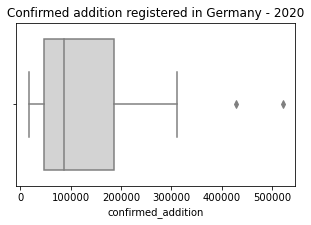

In [34]:
CoronaSUM_confirmed = corona_df_by_region['confirmed_addition']
sns.boxplot(CoronaSUM_confirmed, color='lightgray').set_title('Confirmed addition registered in Germany - 2020');

C:\Users\flori\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


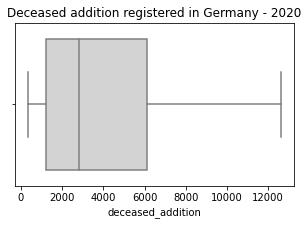

In [35]:
CoronaSUM_deceased = corona_df_by_region['deceased_addition']
sns.boxplot(CoronaSUM_deceased, color='lightgray').set_title('Deceased addition registered in Germany - 2020');

### The number of cases by region per capita

In [36]:
corona_df_by_region['confirmed/pop'] = corona_df_by_region['confirmed_addition']/corona_df_by_region['population']
corona_df_by_region['deceased/pop'] = corona_df_by_region['deceased_addition']/corona_df_by_region['population']
#corona_df_by_region

In [42]:
corona_df_by_region.groupby("region")["deceased/pop", "confirmed/pop"].describe()

<ipython-input-42-6de09c972275>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  corona_df_by_region.groupby("region")["deceased/pop", "confirmed/pop"].describe()


deceased/pop                                                        \
              count      mean std       min       25%       50%       75%   
region                                                                      
DE-BB           1.0  0.001160 NaN  0.001160  0.001160  0.001160  0.001160   
DE-BE           1.0  0.000748 NaN  0.000748  0.000748  0.000748  0.000748   
DE-BW           1.0  0.000717 NaN  0.000717  0.000717  0.000717  0.000717   
DE-BY           1.0  0.000927 NaN  0.000927  0.000927  0.000927  0.000927   
DE-HB           1.0  0.000479 NaN  0.000479  0.000479  0.000479  0.000479   
DE-HE           1.0  0.000905 NaN  0.000905  0.000905  0.000905  0.000905   
DE-HH           1.0  0.000664 NaN  0.000664  0.000664  0.000664  0.000664   
DE-MV           1.0  0.000430 NaN  0.000430  0.000430  0.000430  0.000430   
DE-NI           1.0  0.000514 NaN  0.000514  0.000514  0.000514  0.000514   
DE-NW           1.0  0.000704 NaN  0.000704  0.000704  0.000704  0.000704   
DE-RP           1.0  0.000733 NaN  0.000733  0.000733  0.000733  0.000733   
DE-SH           1.0  0.000418 NaN  0.000418  0.000418  0.000418  0.000418   
DE-SL           1.0  0.000856 NaN  0.000856  0.000856  0.000856  0.000856   
DE-SN           1.0  0.001829 NaN  0.001829  0.001829  0.001829  0.001829   
DE-ST           1.0  0.001038 NaN  0.001038  0.001038  0.001038  0.001038   
DE-TH           1.0  0.001279 NaN  0.001279  0.001279  0.001279  0.001279   

                 confirmed/pop                                              \
             max         count      mean std       min       25%       50%   
region                                                                       
DE-BB   0.001160           1.0  0.029840 NaN  0.029840  0.029840  0.029840   
DE-BE   0.000748           1.0  0.034815 NaN  0.034815  0.034815  0.034815   
DE-BW   0.000717           1.0  0.028109 NaN  0.028109  0.028109  0.028109   
DE-BY   0.000927           1.0  0.032806 NaN  0.032806  0.032806  0.032806   
DE-HB   0.000479           1.0  0.025601 NaN  0.025601  0.025601  0.025601   
DE-HE   0.000905           1.0  0.029435 NaN  0.029435  0.029435  0.029435   
DE-HH   0.000664           1.0  0.027315 NaN  0.027315  0.027315  0.027315   
DE-MV   0.000430           1.0  0.014559 NaN  0.014559  0.014559  0.014559   
DE-NI   0.000514           1.0  0.019943 NaN  0.019943  0.019943  0.019943   
DE-NW   0.000704           1.0  0.029084 NaN  0.029084  0.029084  0.029084   
DE-RP   0.000733           1.0  0.024510 NaN  0.024510  0.024510  0.024510   
DE-SH   0.000418           1.0  0.014193 NaN  0.014193  0.014193  0.014193   
DE-SL   0.000856           1.0  0.028325 NaN  0.028325  0.028325  0.028325   
DE-SN   0.001829           1.0  0.046792 NaN  0.046792  0.046792  0.046792   
DE-ST   0.001038           1.0  0.026570 NaN  0.026570  0.026570  0.026570   
DE-TH   0.001279           1.0  0.034390 NaN  0.034390  0.034390  0.034390   

                            
             75%       max  
region                      
DE-BB   0.029840  0.029840  
DE-BE   0.034815  0.034815  
DE-BW   0.028109  0.028109  
DE-BY   0.032806  0.032806  
DE-HB   0.025601  0.025601  
DE-HE   0.029435  0.029435  
DE-HH   0.027315  0.027315  
DE-MV   0.014559  0.014559  
DE-NI   0.019943  0.019943  
DE-NW   0.029084  0.029084  
DE-RP   0.024510  0.024510  
DE-SH   0.014193  0.014193  
DE-SL   0.028325  0.028325  
DE-SN   0.046792  0.046792  
DE-ST   0.026570  0.026570  
DE-TH   0.034390  0.034390

In [43]:
rcParams['figure.figsize'] = 15,6;

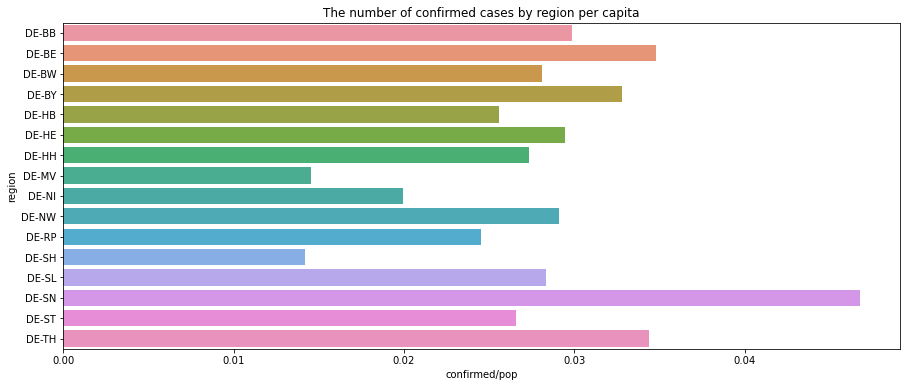

In [44]:
ax = sns.barplot(x="confirmed/pop", y="region", data=corona_df_by_region).set_title('The number of confirmed cases by region per capita');

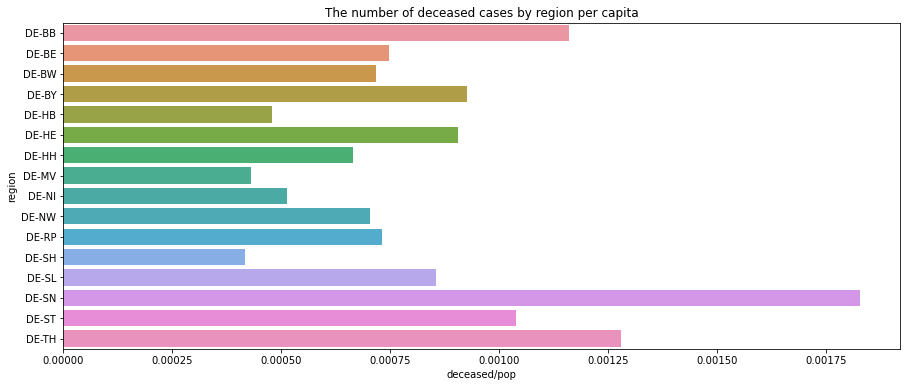

In [45]:
ax = sns.barplot(x="deceased/pop", y="region", data=corona_df_by_region).set_title('The number of deceased cases by region per capita')

### Heatmaps of weather data daily over 2020  (02.13-11.14.)

In [47]:
#set the date as indicies for the heatmap -> df2
datetime_series = pd.to_datetime(weather_data_de['date'])
datetime_index = pd.DatetimeIndex(datetime_series.values)
df2=weather_data_de.set_index(datetime_index)
df2.drop('date', axis=1,inplace=True)
#df2

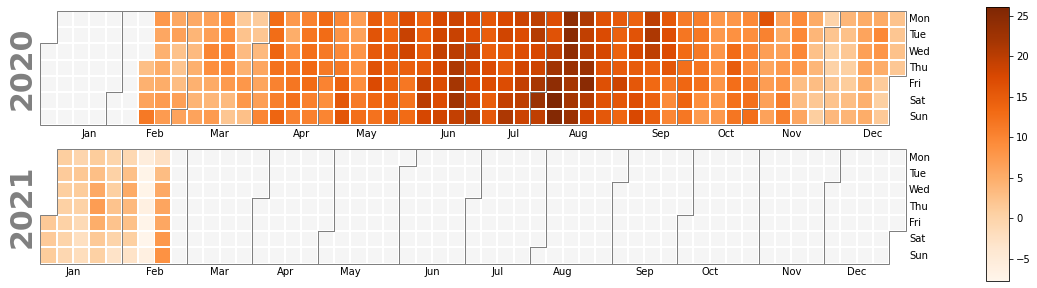

In [62]:
heat_calendar(weather_daily,'Temp_Celsius','Oranges');

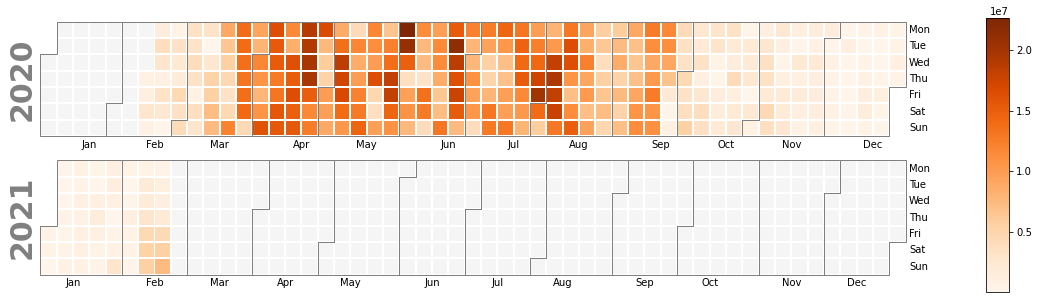

In [63]:
heat_calendar(weather_daily,'SolarRadiation','Oranges');

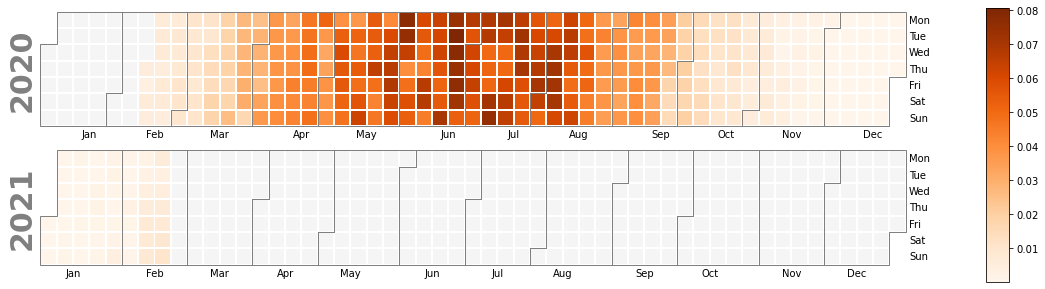

In [69]:
#description
weather_daily['UVIndex'] = weather_daily['UVIndex']/24
heat_calendar(weather_daily,'UVIndex','Oranges');

In [ ]:
calmap.calendarplot(df2['RelativeHumiditySurface'])
plt.title("RelativeHumiditySurface");

In [ ]:
calmap.calendarplot(df2['Surfacepressure'])
plt.title('Surfacepressure');

In [ ]:
calmap.calendarplot(df2['WindSpeed'])
plt.title("WindSpeed");

# Task 1 - Single Variable Analysis

In [56]:
#daily_weather conditions
weather_date = pd.to_datetime(weather_data_de['date'])
weather_month = pd.DataFrame(weather_data_de.groupby(weather_date.dt.month).mean())
weather_daily = pd.DataFrame(weather_data_de.groupby(weather_date).mean())
celsius = pd.DataFrame(weather_daily['TemperatureAboveGround'].subtract(273.15))
#weather_month['Temp_Celsius'] = celsius
weather_daily['Temp_Celsius'] = celsius
weather_daily

,RelativeHumiditySurface,SolarRadiation,Surfacepressure,TemperatureAboveGround,Totalprecipitation,UVIndex,WindSpeed,Temp_Celsius
date,,,,,,,,
2020-02-13,83.550416,9.232296e+05,2.361713e+06,276.080346,5.424938e-03,3.045868,4.677214,2.930346
2020-02-14,87.038057,1.189954e+06,2.385722e+06,277.740734,1.314437e-03,1.875386,3.260335,4.590734
2020-02-15,78.429711,2.849352e+06,2.388378e+06,279.481576,1.507500e-04,3.958054,4.619486,6.331576
2020-02-16,63.587472,7.130768e+05,2.360307e+06,284.575068,4.384375e-03,3.224329,7.988258,11.425068
2020-02-17,73.292063,1.628548e+06,2.373769e+06,280.940914,3.835563e-03,3.951442,6.621854,7.790914
...,...,...,...,...,...,...,...,...
2021-02-17,88.572442,1.161559e+06,2.382257e+06,278.646276,1.361375e-03,2.553174,4.053323,5.496276
2021-02-18,81.035245,2.263309e+06,2.377988e+06,279.161078,2.961500e-03,4.127690,3.631289,6.011078
2021-02-19,80.723951,4.444755e+06,2.384026e+06,278.902828,9.605000e-04,4.426027,3.576306,5.752828


In [ ]:
#similar to how Michele did, creating the corona dataset with the regions
corona_df = raw_data['de_corona']
ss = dict()
for i in country_metadata['country_metadata']:
    ss[i['covid_region_code']] = i['iso3166-2_code']
corona_df['region'] = corona_df['region_code'].map(ss)
corona_df

In [ ]:
#total  of covid cases per region
meta_df = pd.DataFrame(country_metadata['country_metadata'])
sorted_country_metadata = meta_df.sort_values(by = 'iso3166-2_name_en')
corona_by_region  = pd.DataFrame(raw_data['de_corona'].groupby(by = 'region_code').sum())
corona_by_region['iso3166-2_code'] = sorted_country_metadata['iso3166-2_code'].values
corona_by_region['population'] = sorted_country_metadata['population'].values
corona_bar_plot(corona_by_region['iso3166-2_code'],corona_by_region['confirmed_addition'],'bla') #potential use

In [ ]:
#merging the corona dataset with the weather dataset for future associations. 
daily_corona_weather = corona_df.merge(weather_data_de, left_on = ["date", "region"], right_on = ["date", "iso3166-2"])
daily_corona_weather = daily_corona_weather.drop(["region_code", "region"], axis = 1)
daily_corona_weather

## Monthly Analysis

In [ ]:
weather_date = pd.to_datetime(weather_data_de['date'])
weather_2020=pd.DataFrame(weather_data_de[weather_date.dt.year == 2020])
weather_2021=pd.DataFrame(weather_data_de[weather_date.dt.year == 2021])

weather_month_2020 = pd.DataFrame(weather_2020.groupby(weather_date.dt.month).mean())
weather_month_2021 = pd.DataFrame(weather_2021.groupby(weather_date.dt.month).mean())
right_weather_one = weather_month_2020.append(weather_month_2021)
celsius = pd.DataFrame(weather_data_de['TemperatureAboveGround'].subtract(273.15))
right_weather_one['Temp_Celsius'] = celsius
right_weather_one

In [ ]:
weather_mean_bar_plot('SolarRadiation',right_weather_one)

In [ ]:
corona_date = pd.to_datetime(raw_data['de_corona']['date'])
corona_2020=pd.DataFrame(raw_data['de_corona'][corona_date.dt.year == 2020])
corona_2021=pd.DataFrame(raw_data['de_corona'][corona_date.dt.year == 2021])

corona_2021_month_sum = pd.DataFrame(corona_2021.groupby(corona_date.dt.month).sum())
corona_month_sum = pd.DataFrame(corona_2020.groupby(corona_date.dt.month).sum())
corona_month_mean = pd.DataFrame(corona_2020.groupby(corona_date.dt.month).mean())
right_one = corona_month_sum.append(corona_2021_month_sum)
right_one

In [ ]:
corona_total_bar_plot('confirmed_addition',right_one[1:])

In [ ]:
corona_total_bar_plot('deceased_addition',right_one[1:])

## Region and Weather Mean

In [ ]:
weather_by_region = pd.DataFrame(weather_data_de.groupby(by = 'iso3166-2').mean())
weather_by_region

# Task 2 - Associations

## Daily Associations

#### Visualize linear regression model

In [ ]:
#a scatterplot of two variables, x and y, 
#regression line - fit a line to the data by calculating R^2 (sum of least squares)
fig, ax = plt.subplots()
ax2 = ax.twinx() #This allows the common axes (flow rate) to be shared
sns.regplot(x="confirmed_addition", y="RelativeHumiditySurface", data=daily_corona_weather, ax=ax, color="black", ci=None, scatter_kws={'alpha': 0.5},line_kws={'lw':4})
sns.regplot(x="confirmed_addition", y="UVIndex", data=daily_corona_weather, color="gray", ax=ax2, ci=None, scatter_kws={'alpha': 0.5}, line_kws={'lw':4})

ax2.legend(handles=[a.lines[0] for a in [ax,ax2]], 
           labels=["Temp_Celsius", "UVIndex"])
plt.show()

In [71]:
weather_headers = ['RelativeHumiditySurface', 'SolarRadiation', 'Surfacepressure', 'TemperatureAboveGround',
             'Totalprecipitation', 'UVIndex', 'WindSpeed','Temp_Celsius']
significance_threshold = 0.001 / (len(weather_headers) * 3)
daily_corona_weather['Temp_Celsius'] = celsius

NameError: name 'daily_corona_weather' is not defined

### Pearson association for daily_corona_weather for original dataset

In [ ]:
pearson_association(daily_corona_weather,'confirmed_addition',weather_headers,significance_threshold)

### Spearman association for daily_corona_weather for original dataset.

In [ ]:
spearman_association(daily_corona_weather,'confirmed_addition',weather_headers,significance_threshold)

### Pearson asscociation for daily_corona_weather, with logtransformation of confirmed_addition

In [ ]:
pearson_log(daily_corona_weather,'confirmed_addition',weather_headers,significance_threshold)

### sm.ols (Least Squares) multivariate regression

Values here may be misleading. This is because the multivariate regression, when looking at specific variables, it keeps all the other variables constant.

In [ ]:
df = sm.add_constant(daily_corona_weather)
weather_headers.extend(["const"])

est = sm.OLS(df["confirmed_addition"], df[weather_headers], hasconst = True).fit()
print(est.summary())

Here TemperatureAboveGround is a misleading variable, since in the previous sections we analysed that having a higher temperature leads to fewer cases. Though in this multiplevariate regression it is found out that a higher temperature increases the number of cases, this contradicts all prior analysis. The reason for this is that the multivariate regression keeps all other variables constant. That is, a day with the exact same weather conditions, besides the temperature being higher, will lead to more cases. To this there could be multiple reasons for this to occur, though a major and probable reason could be that people go outside during high temperatures, which in turn will lead to people not being isolated and thus there will be a higher probability of people getting a Covid-19 infection. 

Thus all these weather variables lead to change in human behavior, which results in changes in the amount of Covid-19 cases.

In [ ]:
est = sm.OLS(df["deceased_addition"], df[weather_headers], hasconst = True).fit()
print(est.summary())

All the weather variables does not result in anything interesting to be discorvered. From the multivariate regression it is apparent that more people die, with a covid-19 infection, during higher solar radiation. It also shows that fewer people die when the total precipitation is higher. Intuitively these variables does change the human behavior, but in no way that would cause them to reduce or increase the number of deaths caused by covid-19. Also the people dying of Covid-19 is most likely in a hospital bed and is under extensive care, thus intuitively these weather variables would not lead to changes in covid-19 deaths. 

The only explanation would be that the hospital care is worsened during good weather and better during poor weather. Which also does not make much sense intuitively.
   

## Monthly Associations

In [ ]:
#corona and weather conditions grouped by months
df_monthly_sum = corona_month_sum.merge(weather_month_2020,left_on = 'date',right_on = 'date')

#### Visualize linear regression model

In [ ]:
#a scatterplot of two variables, x and y, 
#regression line - fit a line to the data by calculating R^2 (sum of least squares)
fig, ax = plt.subplots()
ax2 = ax.twinx() #This allows the common axes (flow rate) to be shared
sns.regplot(x="confirmed_addition", y="RelativeHumiditySurface", data=df_monthly_sum, ax=ax, color="black", ci=None,line_kws={'lw':4})
sns.regplot(x="confirmed_addition", y="UVIndex", data=df_monthly_sum, color="gray", ax=ax2, ci=None, line_kws={'lw':4})

ax2.legend(handles=[a.lines[0] for a in [ax,ax2]], 
           labels=["Temp_Celsius", "UVIndex"])
plt.show()

In [75]:
significance_threshold_monthly = 0.5 / (len(weather_headers) * 3)
weather_headers_month = ['RelativeHumiditySurface', 'SolarRadiation', 'Surfacepressure', 'TemperatureAboveGround',
             'Totalprecipitation', 'UVIndex', 'WindSpeed']
print(significance_threshold_monthly)

0.020833333333333332


Here the significance threshhold is increased due to the grouping of the data into months. This means that the breakpoint of where a variable is as not being correlated by chance is higher, which means that the certainty that the variable is a correlated by chance is less precise. 

#### Corona Cases per Month

In [ ]:
pearson_association(df_monthly_sum,'confirmed_addition',weather_headers_month,significance_threshold_monthly)

In [ ]:
spearman_association(df_monthly_sum,'confirmed_addition',weather_headers_month,significance_threshold_monthly)

In [ ]:
pearson_log(df_monthly_sum,'confirmed_addition',weather_headers_month,significance_threshold_monthly)

From these multivariate regressions it is apparent from the pearson that there is a correlation between the monthly total of Covid-19 cases and RelativeHumiditySurface, SolarRadiation and UVIndex. These variables tend to be higher during the summer, where there was a decrease in Covid-19 cases, thus this makes sense. Though in the spearman there is also seen high correlations, though the p-value is too high for us to assume that it has not happend by chance.

#### Corona Deaths per month

In [ ]:
pearson_association(df_monthly_sum,'deceased_addition',weather_headers_month,significance_threshold_monthly)

In [ ]:
spearman_association(df_monthly_sum,'deceased_addition',weather_headers_month,significance_threshold_monthly)

In [ ]:
pearson_log(df_monthly_sum[1:],'deceased_addition',weather_headers_month,significance_threshold_monthly) #interesting, check temperature above ground

The analysis of the corona cases/deaths per month could be interesting when it is analyzed how infectious one strain is from another. This would be quite hard to do daily because there is really hard that 1st of February 2020 would have the same weather conditions as 1st of February 2021. Therefore, there is a higher chance that the overall weather conditions in February 2020 to be the similar to February 2021.

### Dummy Variable Analysis

In [ ]:
daily_corona_weather['Lockdown'] = '0'
daily_corona_weather.loc[(daily_corona_weather["date"] >= "2020-11-02") & (daily_corona_weather["date"] <= "2021-03-07"), "Lockdown"] = '1'
daily_corona_weather = daily_corona_weather.drop(["date", "iso3166-2"], axis = 1)
#daily_corona_weather

In [ ]:
#data taken from https://en.wikipedia.org/wiki/COVID-19_pandemic_in_Germany - Government Reactions
mask = (corona_df['date'] > "2020-11-02") & (corona_df['date'] <= "2021-03-07")
corona_daily_sum = corona_df.groupby(corona_df['date']).sum().reset_index()
corona_daily_sum_lockdown = corona_df[mask].groupby(corona_df[mask]['date']).sum().reset_index()

In [ ]:
corona_line_plot(corona_daily_sum,'date','confirmed_addition','Corona lockdown plot')

In [ ]:
corona_line_plot(corona_daily_sum,'date','deceased_addition','Corona lockdown plot')

Data taken from https://en.wikipedia.org/wiki/COVID-19_pandemic_in_Germany - Government Reactions

- 15th March, borders to Austria, Denmark, France, Luxembourg and Switzerland were closed (light-red)
- 22nd March, curfews were imposed in six German states while other states prohibited physical contact with more than one person from outside one's household. (dark-red)
- 15th April loosening of restrictions (blue)
- 2nd November a partial lockdown was implemented, in which physical distancing rules were tightened while schools and kindergartens remained open, only temporarily halted the rise in case numbers (light-red)
- 15th December a hard lockdown was implemented (dark-red)
- 26th December 2020 - Vaccinations with the BioNTech–Pfizer COVID-19 vaccine began  (green)

In [ ]:
corona_bar_plot(corona_daily_sum_lockdown['date'],corona_daily_sum_lockdown['confirmed_addition'],'Corona Lockdown Cases')

In [ ]:
corona_bar_plot(corona_daily_sum_lockdown['date'],corona_daily_sum_lockdown['deceased_addition'],'Corona lockdown plot')

In [ ]:
x = ['RelativeHumiditySurface', 'SolarRadiation', 'Surfacepressure', 'TemperatureAboveGround',
             'Totalprecipitation', 'UVIndex', 'WindSpeed','Lockdown','const']
df1 = sm.add_constant(daily_corona_weather)
est1 = sm.OLS(df1['confirmed_addition'], df1[x].astype(float), hasconst = True).fit()
print(est1.summary()) #very weird values

# Task 3 - Map visualization

In [ ]:
# First task, we need to convert the region names in the corona data with the iso3166-2 codes
# To do so, first we need a dictionary mapping the region name to the code
region_map = {country_metadata["country_metadata"][i]["covid_region_code"]: country_metadata["country_metadata"][i]["iso3166-2_code"] for i in range(len(country_metadata["country_metadata"]))}

# Then, we use the Series.map function
raw_data["de_corona"]["region"] = raw_data["de_corona"]["region_code"].map(region_map)

# Second task, we can now calculate how many cases there were in total for the region
corona_df_by_region = raw_data["de_corona"].groupby(by = "region")["confirmed_addition"].sum().reset_index()
dead_by_region      = raw_data["de_corona"].groupby(by = "region")["deceased_addition"].sum().reset_index()
# If we want to add population data, we need to create another dictionary from the country metadata
# In this case, we need to map from the region iso3166-2 code to the region's population
population_map = {
    country_metadata["country_metadata"][i]["iso3166-2_code"]: 
    country_metadata["country_metadata"][i]["population"] 
    for i in range(len(country_metadata["country_metadata"]))}

# Then we can map, just like before
corona_df_by_region["population"] = corona_df_by_region["region"].map(population_map)

corona_df_by_region["ratio"] = corona_df_by_region["confirmed_addition"]/corona_df_by_region["population"]

## Total number of Cases of Covid-19 on a regional basis

In [76]:
n_cases = folium.Map(location = [51.5, 10.7], zoom_start = 6)

folium.Choropleth(
    geo_data = shape,
    name = "cases",
    data = corona_df_by_region,
    columns = ["region", "confirmed_addition"],
    key_on = "properties.iso_3166_2",
    fill_color = "OrRd", 
    fill_opacity = 0.7,
    line_opacity = 0.2,
    highlight=True,
    legend_name = "Number of Cases of Covid-19").add_to(n_cases)
n_cases

## Total number of deceased with a confirmed Covid-19 infection on a regional basis

In [ ]:
dead = folium.Map(location = [51.5, 10.7], zoom_start = 6)

folium.Choropleth(
    geo_data = shape,
    name = "cases",
    data = dead_by_region,
    columns = ["region", "deceased_addition"],
    key_on = "properties.iso_3166_2",
    fill_color = "Greys", 
    fill_opacity = 0.7,
    line_opacity = 0.2,
    highlight=True,
    legend_name = "Number of Deceased with an covid-19 infection").add_to(dead)
dead

## Population on a regional basis 

In [ ]:
p_cases = folium.Map(location = [51.5, 10.7], zoom_start = 6)
folium.Choropleth(
    geo_data = shape,
    name = "population",
    data = corona_df_by_region,
    columns = ["region", "population"],
    key_on = "properties.iso_3166_2",
    fill_color = "YlGn", 
    fill_opacity = 0.7,
    line_opacity = 0.2,
    highlight=True,
    legend_name = "Population").add_to(p_cases)
p_cases

## Number of Cases pr. population of region

In [ ]:
r_cases = folium.Map(location = [51.5, 10.7], zoom_start = 6)

tiles = ['stamenwatercolor', 'cartodbpositron', 'openstreetmap', 'stamenterrain']
for tile in tiles:
    folium.TileLayer(tile).add_to(r_cases)

folium.Choropleth(
    geo_data = shape,
    name = "cases",
    data = corona_df_by_region,
    columns = ["region", "ratio"],
    key_on = "properties.iso_3166_2",
    fill_color = "OrRd", 
    fill_opacity = 0.7,
    line_opacity = 0.2,
    legend_name = "Number of Cases pr. population of region",
    highlight=True
).add_to(r_cases)

folium.LayerControl().add_to(r_cases)

r_cases

## UVIndex on a regional basis

The UVIndex is a daily sum, this is handled by dividing by 24, because there is 24 hours in a day. This will though result in very small UVIndex values, because UVIndex during the night is taken into account.

In [ ]:
# dividing by 24 since there is 24 hours in a day, though this takes into account night where the uvindex is 
# really small/nonexsistent
# Could be argued that it should be divided by 16-18 since these are the hours where the sun is present. 
UV_by_region = processed_data["weather"].groupby(by = "iso3166-2")["UVIndex"].mean().reset_index()
UV_by_region["UVIndex_scaled"] = UV_by_region["UVIndex"]/24

In [ ]:
uv_index = folium.Map(location = [51.5, 10.7], zoom_start = 6)

folium.Choropleth(
    geo_data = shape,
    name = "uv-index",
    data = UV_by_region,
    columns = ["iso3166-2", "UVIndex_scaled"],
    key_on = "properties.iso_3166_2",
    fill_color = "OrRd", 
    fill_opacity = 0.7,
    line_opacity = 0.2,
    highlight=True,
    legend_name = "UVIndex",
    smooth_factor=0).add_to(uv_index)
uv_index

## Temperature Above Ground on a regional basis

The Temperature Above Ground is a daily sum, this means that the data is flawed and is a lot higher than expected. This is handled by dividing by 24, because there is 24 hours in a day. This will though result in very small temperature values, because the temperature during the night is taken into account. Considering the flaws here this is still a more accurate measure then what the original data would have been. 

In [ ]:
temp_by_region = processed_data["weather"].groupby(by = "iso3166-2")["TemperatureAboveGround"].mean().reset_index()
temp_by_region["TemperatureAboveGround_scaled"] = temp_by_region["TemperatureAboveGround"]/24

In [ ]:
TAG = folium.Map(location = [51.5, 10.7], zoom_start = 6)

folium.Choropleth(
    geo_data = shape,
    name = "uv-index",
    data = temp_by_region,
    columns = ["iso3166-2", "TemperatureAboveGround_scaled"],
    key_on = "properties.iso_3166_2",
    fill_color = "OrRd", 
    fill_opacity = 0.7,
    line_opacity = 0.2,
    highlight=True,
    legend_name = "average Temperature Above Ground on a daily basis").add_to(TAG)
TAG

## Multiple plots on a regional and monthy basis

If a region only has missing data in a given category, the region will be colored in purple.

In [ ]:
raw_data['de_corona']['month'] = raw_data['de_corona']['date'].dt.strftime('%B')
raw_data['de_corona']['year'] = raw_data['de_corona']['date'].dt.strftime('%Y')
raw_data["de_corona"]["population"] = raw_data["de_corona"]["region"].map(population_map)
raw_data["de_corona"]["confirmed_addition_ratio"] = raw_data["de_corona"]["confirmed_addition"]/raw_data["de_corona"]["population"]

In [ ]:
cases_2020_monthly = raw_data["de_corona"][(raw_data["de_corona"]["year"] == "2020")].groupby(["month", "region"]).sum()
cases_2021_monthly = raw_data["de_corona"][(raw_data["de_corona"]["year"] == "2021")].groupby(["month", "region"]).sum()

In [77]:
population_map

{'DE-BW': 11069533,
 'DE-BY': 13076721,
 'DE-BE': 3644826,
 'DE-BB': 2511917,
 'DE-HB': 682986,
 'DE-HH': 1841179,
 'DE-HE': 6265809,
 'DE-NI': 7982448,
 'DE-MV': 1609675,
 'DE-NW': 17932651,
 'DE-RP': 4084844,
 'DE-SL': 990509,
 'DE-SN': 4077937,
 'DE-ST': 2208321,
 'DE-SH': 2896712,
 'DE-TH': 2143145}

### Confirmed addition pr population of region

In [ ]:
confirmed_addition_ratio_maps = dict()
for i in list(raw_data["de_corona"][(raw_data["de_corona"]["year"] == "2020")]["month"].unique()):
    n_cases = folium.Map(location = [51.5, 10.7], zoom_start = 6)
    
    folium.map.Marker(
    [54.5, 2],
    icon=DivIcon(
        icon_size=(400,50),
        icon_anchor=(0,0),
        html='<div style="font-size: 20pt">{}</div>'.format(i),
        )
    ).add_to(n_cases)
    
    folium.Choropleth(
        geo_data = shape,
        name = "cases",
        data = cases_2020_monthly.loc[i].reset_index(),
        columns = ["region", "confirmed_addition_ratio"],
        key_on = "properties.iso_3166_2",
        fill_color = "OrRd", 
        fill_opacity = 0.7,
        line_opacity = 0.2,
        highlight=True,
        nan_fill_color = "purple",
        legend_name = "Number of Cases of Covid-19 pr. population of region in {} 2020".format(i)).add_to(n_cases)
    confirmed_addition_ratio_maps[i+"-2020"] = n_cases
for i in list(raw_data["de_corona"][(raw_data["de_corona"]["year"] == "2021")]["month"].unique()):
    n_cases = folium.Map(location = [51.5, 10.7], zoom_start = 6)

    folium.map.Marker(
    [54.5, 2],
    icon=DivIcon(
        icon_size=(400,50),
        icon_anchor=(0,0),
        html='<div style="font-size: 20pt">{}</div>'.format(i),
        )
    ).add_to(n_cases)
    
    folium.Choropleth(
        geo_data = shape,
        name = "cases",
        data = cases_2021_monthly.loc[i].reset_index(),
        columns = ["region", "confirmed_addition_ratio"],
        key_on = "properties.iso_3166_2",
        fill_color = "OrRd", 
        fill_opacity = 0.7,
        line_opacity = 0.2,
        highlight=True,
        nan_fill_color = "purple",
        legend_name = "Number of Cases of Covid-19 pr. population of region in {} 2021".format(i)).add_to(n_cases)
    confirmed_addition_ratio_maps[i+"-2021"] = n_cases    

### Confirmed addition

In [ ]:
confirmed_addition_maps = dict()
for i in list(raw_data["de_corona"][(raw_data["de_corona"]["year"] == "2020")]["month"].unique()):
    n_cases = folium.Map(location = [51.5, 10.7], zoom_start = 6)
    
    folium.map.Marker(
    [54.5, 2],
    icon=DivIcon(
        icon_size=(400,50),
        icon_anchor=(0,0),
        html='<div style="font-size: 20pt">{}-2020</div>'.format(i),
        )
    ).add_to(n_cases)
    
    folium.Choropleth(
        geo_data = shape,
        name = "cases",
        data = cases_2020_monthly.loc[i].reset_index(),
        columns = ["region", "confirmed_addition"],
        key_on = "properties.iso_3166_2",
        fill_color = "OrRd", 
        fill_opacity = 0.7,
        line_opacity = 0.2,
        highlight=True,
        nan_fill_color = "purple",
        legend_name = "Number of Cases of Covid-19 in {} 2020".format(i)).add_to(n_cases)
    confirmed_addition_maps[i+"-2020"] = n_cases
for i in list(raw_data["de_corona"][(raw_data["de_corona"]["year"] == "2021")]["month"].unique()):
    n_cases = folium.Map(location = [51.5, 10.7], zoom_start = 6)

    folium.map.Marker(
    [54.5, 2],
    icon=DivIcon(
        icon_size=(400,50),
        icon_anchor=(0,0),
        html='<div style="font-size: 20pt">{}-2021</div>'.format(i),
        )
    ).add_to(n_cases)
    
    folium.Choropleth(
        geo_data = shape,
        name = "cases",
        data = cases_2021_monthly.loc[i].reset_index(),
        columns = ["region", "confirmed_addition"],
        key_on = "properties.iso_3166_2",
        fill_color = "OrRd", 
        fill_opacity = 0.7,
        line_opacity = 0.2,
        highlight=True,
        nan_fill_color = "purple",
        legend_name = "Number of Cases of Covid-19 in {} 2021".format(i)).add_to(n_cases)
    confirmed_addition_maps[i+"-2021"] = n_cases   
confirmed_addition = ["other_notebooks/maps/confirmed_addition/"+i+".png" for i in confirmed_addition_maps.keys()]
images = []
for filename in confirmed_addition:
    images.append(imageio.imread(filename))
imageio.mimsave('other_notebooks/map_gifs/confirmed_addition_maps.gif', images, duration=2)

### Deceased Addition monthly

In [ ]:
deceased_addition_maps = dict()
for i in list(raw_data["de_corona"][(raw_data["de_corona"]["year"] == "2020")]["month"].unique()):
    n_cases = folium.Map(location = [51.5, 10.7], zoom_start = 6)

    folium.map.Marker(
    [54.5, 2],
    icon=DivIcon(
        icon_size=(400,50),
        icon_anchor=(0,0),
        html='<div style="font-size: 20pt">{}-2020</div>'.format(i),
        )
    ).add_to(n_cases)
    
    folium.Choropleth(
        geo_data = shape,
        name = "cases",
        data = cases_2020_monthly.loc[i].reset_index(),
        columns = ["region", "deceased_addition"],
        key_on = "properties.iso_3166_2",
        fill_color = "Greys", 
        fill_opacity = 0.7,
        line_opacity = 0.2,
        highlight=True,
        nan_fill_color = "purple",
        legend_name = "Number of deceased with a Covid-19 infection in {} 2020".format(i)).add_to(n_cases)
    deceased_addition_maps[i+"-2020"] = n_cases
for i in list(raw_data["de_corona"][(raw_data["de_corona"]["year"] == "2021")]["month"].unique()):
    n_cases = folium.Map(location = [51.5, 10.7], zoom_start = 6)

    folium.map.Marker(
    [54.5, 2],
    icon=DivIcon(
        icon_size=(400,50),
        icon_anchor=(0,0),
        html='<div style="font-size: 20pt">{}-2021</div>'.format(i),
        )
    ).add_to(n_cases)
    
    folium.Choropleth(
        geo_data = shape,
        name = "cases",
        data = cases_2021_monthly.loc[i].reset_index(),
        columns = ["region", "deceased_addition"],
        key_on = "properties.iso_3166_2",
        fill_color = "Greys", 
        fill_opacity = 0.7,
        line_opacity = 0.2,
        highlight=True,
        nan_fill_color = "purple",
        legend_name = "Number of deceased with a Covid-19 infection in {} 2021".format(i)).add_to(n_cases)
    deceased_addition_maps[i+"-2021"] = n_cases   
deceased_addition = ["other_notebooks/maps/deceased_addition/"+i+".png" for i in confirmed_addition_maps.keys()]
images = []
for filename in deceased_addition:
    images.append(imageio.imread(filename))
imageio.mimsave('other_notebooks/map_gifs/deceased_addition_maps.gif', images, duration=2)

### Viewing the maps

All the monthly maps can be ascessed by doing 
```python
deceased_addition_maps["January-2020"]
confirmed_addition_maps["January-2020"]
confirmed_addition_ratio_maps["January-2020"]
```
Missing data, or there was no recorded data in that region, the color of the region will be purple

Month and year can be changed

In [ ]:
confirmed_addition_maps["January-2020"]

![SegmentLocal](other_notebooks/map_gifs/confirmed_addition_maps.gif)

In [ ]:
deceased_addition_maps["January-2020"]

![SegmentLocal](other_notebooks/map_gifs/deceased_addition_maps.gif)

In [ ]:
confirmed_addition_ratio_maps["January-2020"]

##  Task 4: Open question
Use the data to formulate, motivate, answer, and discuss another research question of your choice. For example, compare your country to another one in the dataset; or investigate additional variables that you could
find elsewhere (e.g. total population, population density, population demographics such as age distribution,
number of elders, etc); or identify if there are temporal patterns (is one variable more important in some
months? Are weekends different from weekdays? Etc), ..


##### We loaded an external data set from the website of 'Robert Koch Institut' (RKI) to explore the role of age in potentially driving differences in infection spread.
The data set is about  COVID-19 cases by age group / 100,000 inhabitants in Germany from the 17th of March 2020 to the 2nd of March 2021.  
https://www.rki.de/DE/Content/InfAZ/N/Neuartiges_Coronavirus/Daten/Altersverteilung.html

#### The weekly mean of total confirmed cases per 100.000 inhabitants across age groups
We added the mean of the weekly cases by age to the table to get a quick insight into the age distribution.

In [ ]:
raw_data['age_pop']['mean'] = raw_data['age_pop'].mean(axis=1)
#raw_data['age_pop']

In [ ]:
 raw_data['age_pop']['mean'].describe()

#### Visualize linear regression model

In [ ]:
rcParams['figure.figsize'] = 15,6
sns.set_style("whitegrid");

In [ ]:
ax = sns.barplot(x="mean", y="Altersgruppe", data=raw_data['age_pop']).set_title('The weekly mean of total confirmed cases per 100.000 people across age groups')

The weekly registered infections among people above 90 is extremely hihger than other age groups. 

The reason seems not to be the population size of each group. (RKI: 40-59-year-olds make up the largest age group in Germany, at 23.6 million people, the next-largest age group was 65 years and older, at 18.09 million.)

#### Temporal distribution of cases across age groups

In [ ]:
#change the original data structure

df_T = raw_data['age_pop'].T
modified = df_T.reset_index()
new_header = modified.iloc[0] #grab the first row for the header
modified = modified[1:] #take the data less the header row
modified.columns = new_header #set the header row as the df header
modified.rename(columns={"Altersgruppe":"date"}, inplace=True)
modified = modified.drop([53])
modified['date'] = modified['date'].astype(str) + '_2' #2 means Tuesday
modified['date'] =  pd.to_datetime(modified['date'], format='%Y_%W_%w')

for column in modified:
    modified.iloc[:, 1:21] = modified.iloc[:, 1:21].astype(float)

# merge age groups
modified['0-19'] = modified.loc[:,['0 - 4','5 - 9', '10 - 14', '15 - 19']].sum(axis=1)
modified['20-39'] = modified.loc[:,['20 - 24','25 - 29', '30 - 34', '35 - 39']].sum(axis=1)
modified['40-59'] = modified.loc[:,['40 - 44', '45 - 49', '50 - 54', '55 - 59']].sum(axis=1)
modified['60-79'] = modified.loc[:,['60 - 64','65 - 69', '70 - 74', '75 - 79']].sum(axis=1)
modified['80+'] = modified.loc[:,['80 - 84', '85 - 89', '90+']].sum(axis=1)
#modified

The pandemic is exhibiting seasonal patterns in its spread. It is clear that there is a peak in the number of cases in the winter period of 2020-2021 and the number of cases are low during the summer of 2020. 
Next, the distribution of these specific periods will be plotted by ages.

In [ ]:
x = modified.drop(modified.columns.difference(['date', '0-19', '20-39', '40-59', '60-79', '80+']), axis=1)
melt_modified = x.melt('date', var_name='age_gaps',  value_name='cases')

g = sns.lineplot(x="date", y="cases", hue='age_gaps', data=melt_modified).set_title('All weekly registered cases in Germany by age groups')

In [ ]:
x = modified.drop(modified.columns.difference(['date', '0-19', '20-39', '40-59', '60-79', '80+']), axis=1)
melt_modified = x.melt('date', var_name='age_gaps',  value_name='cases')

fig, ax = plt.subplots()
chart = sns.barplot(data=melt_modified, ax=ax,x="date",y="cases", hue='age_gaps').set_title('All weekly registered cases in Germany by age groups')

##XTICK LABELS
## freq of showing dates, set the frequency for labelling the xaxis
freq = int(2)
# set the xlabels as the date data for the given labelling frequency,
# also use only the date for the label
ax.set_xticklabels(melt_modified.iloc[::freq]["date"].dt.strftime("%d-%b-%y"))
# set the xticks at the same frequency as the xlabels
xtix = ax.get_xticks()
ax.set_xticks(xtix[::freq])
# nicer label format for dates
fig.autofmt_xdate()

plt.show()

In [ ]:
mask_winter = (melt_modified['date'].dt.month > 10)
winter = melt_modified[mask_winter]

g = sns.lineplot(x="date", y="cases", hue='age_gaps', data=winter).set_title('2020-2021: WINTER: All weekly registered cases in Germany by age groups');

In [ ]:
fig, ax = plt.subplots()
chart = sns.barplot(data=winter, ax=ax,x="date",y="cases", hue='age_gaps').set_title('2020-2021 WINTER: All weekly registered cases in Germany by age groups')

##XTICK LABELS
ax.set_xticklabels(melt_modified["date"].dt.strftime("%d-%b-%y"));

In [ ]:
mask_summer = ((melt_modified['date'].dt.month < 9) & (melt_modified['date'].dt.month > 5))
summer = melt_modified[mask_summer]

g = sns.lineplot(x="date", y="cases", hue='age_gaps', data=summer).set_title('2020 SUMMER: All weekly registered cases in Germany by age groups');

In [ ]:
fig, ax = plt.subplots()
chart = sns.barplot(data=summer, ax=ax,x="date",y="cases", hue='age_gaps').set_title('2020 SUMMER: All weekly registered cases in Germany by age groups')

##XTICK LABELS
ax.set_xticklabels(melt_modified["date"].dt.strftime("%d-%b-%y"));

However, in summer time, when the number of all cases are low, the proportion of the infected among young adults are higher, among the age group 20-39 the highest.

By investigating the possible connections between the weather variables and the number of cases by age groups, the focus will be on the two most interesting ones that are not following the pattern: people from 20 to 39 years and above 80.

#### Weather and ages

In [ ]:
#merge corona_age & weather WEEKLY for plots
#corona age: 2020.03.12 - 2021.03.02.  - weather: 2020-02-13 - 2020.11.14.

#prepare weather data to merge without regions
df_w = weather_data_de.copy()
#sum some weather values:
df_w_sum = df_w.groupby('date')['RelativeHumiditySurface', 'SolarRadiation', 'Surfacepressure', 'Totalprecipitation'].sum()
#take the mean some weather values:
df_w_mean = df_w.groupby('date')['TemperatureAboveGround', 'UVIndex', 'WindSpeed'].mean()
df_w_noregions = df_w_sum.merge(df_w_mean, left_on = ["date"], right_on = ["date"]) 
#date index to column data:
df_w_noregions.reset_index(level=0, inplace=True)

#merge (modified is the weekly corona data by age)
weekly_coronaAge_weather = modified.merge(df_w_noregions, left_on = ["date"], right_on = ["date"])
weekly_coronaAge_weather.drop_duplicates(subset='date');

celsius = pd.DataFrame(weekly_coronaAge_weather['TemperatureAboveGround'].subtract(273.15))
weekly_coronaAge_weather['Temp_Celsius'] = celsius

#modified
#df_w_noregions
#weekly_coronaAge_weather


### Visualize linear regression model for corona cases by age groups and weather variables

In [ ]:
#a scatterplot of two variables, x and y, 
#regression line - fit a line to the data by calculating R^2 (sum of least squares)
fig, ax = plt.subplots()
ax2 = ax.twinx() #This allows the common axes (flow rate) to be shared
sns.regplot(x="80+", y="Temp_Celsius", data=weekly_coronaAge_weather, ax=ax, color="black", ci=None)
sns.regplot(x="80+", y="UVIndex", data=weekly_coronaAge_weather, color="orange", ax=ax2, ci=None)

ax2.legend(handles=[a.lines[0] for a in [ax,ax2]], 
           labels=["Temp_Celsius", "UVIndex"])
plt.show()

In [ ]:
#a scatterplot of two variables, x and y, 
#then fit the regression model y ~ x and plot the resulting regression line 
#and a 95% confidence interval for that regression:
fig, ax = plt.subplots()
ax2 = ax.twinx() #This allows the common axes (flow rate) to be shared
sns.regplot(x="20-39", y="Temp_Celsius", data=weekly_coronaAge_weather, ax=ax, color="black", ci=None)
sns.regplot(x="20-39", y="UVIndex", data=weekly_coronaAge_weather, color="orange", ax=ax2, ci=None)

ax2.legend(handles=[a.lines[0] for a in [ax,ax2]], 
           labels=["Temp_Celsius", "UVIndex"])
plt.show()

In [ ]:
#a scatterplot of two variables, x and y, 
#then fit the regression model y ~ x and plot the resulting regression line 
#and a 95% confidence interval for that regression:
fig, ax = plt.subplots()
ax2 = ax.twinx() #This allows the common axes (flow rate) to be shared
sns.regplot(x="80+", y="RelativeHumiditySurface", data=weekly_coronaAge_weather, ax=ax, color="black", ci=None)
sns.regplot(x="80+", y="Totalprecipitation", data=weekly_coronaAge_weather, color="orange", ax=ax2, ci=None)

ax2.legend(handles=[a.lines[0] for a in [ax,ax2]], 
           labels=["Humidity", "Precipitation"])
plt.show()

In [ ]:
#a scatterplot of two variables, x and y, 
#then fit the regression model y ~ x and plot the resulting regression line 
#and a 95% confidence interval for that regression:
fig, ax = plt.subplots()
ax2 = ax.twinx() #This allows the common axes (flow rate) to be shared
sns.regplot(x="20-39", y="RelativeHumiditySurface", data=weekly_coronaAge_weather, ax=ax, color="black", ci=None)
sns.regplot(x="20-39", y="Totalprecipitation", data=weekly_coronaAge_weather, color="orange", ax=ax2, ci=None)

ax2.legend(handles=[a.lines[0] for a in [ax,ax2]], 
           labels=["Humidity", "Precipitation"])
plt.show()

In [ ]:
#a scatterplot of two variables, x and y, 
#then fit the regression model y ~ x and plot the resulting regression line 
#and a 95% confidence interval for that regression:
fig, ax = plt.subplots()
ax2 = ax.twinx() #This allows the common axes (flow rate) to be shared
sns.regplot(x="80+", y="SolarRadiation", data=weekly_coronaAge_weather, ax=ax, color="black", ci=None)
sns.regplot(x="80+", y="WindSpeed", data=weekly_coronaAge_weather, color="orange", ax=ax2, ci=None)

ax2.legend(handles=[a.lines[0] for a in [ax,ax2]], 
           labels=["Solar Radiation", "Wind Speed"])
plt.show()

In [ ]:
#a scatterplot of two variables, x and y, 
#then fit the regression model y ~ x and plot the resulting regression line 
#and a 95% confidence interval for that regression:
fig, ax = plt.subplots()
ax2 = ax.twinx() #This allows the common axes (flow rate) to be shared
sns.regplot(x="20-39", y="SolarRadiation", data=weekly_coronaAge_weather, ax=ax, color="black", ci=None)
sns.regplot(x="20-39", y="WindSpeed", data=weekly_coronaAge_weather, color="orange", ax=ax2, ci=None)

ax2.legend(handles=[a.lines[0] for a in [ax,ax2]], 
           labels=["Solar Radiation", "Wind Speed"])
plt.show()

### Multivariable linear regression using statsmodel for daily_coronaAge_weather 80+
3.17. - 11-14.

Let's look all the weather variables. Are there any differencies how the different weather variables can influence the number of cases by that two specific age groups? 

In [ ]:
#DAILY DATA
#There is data for 52 weeks: create daily data - divide the case numbers by 7
modified['date'] = pd.to_datetime(modified['date'])
daily_age = modified.set_index('date').resample('d').mean().ffill().div(7).reset_index()


#changes in weather data: change values: sum and mean
#df_w = de_weather.copy()
#df_w_sum = df_w.groupby('date')['RelativeHumiditySurface', 'SolarRadiation', 'Surfacepressure', 'Totalprecipitation'].sum()
#df_w_mean = df_w.groupby('date')['TemperatureAboveGround', 'UVIndex', 'WindSpeed'].mean()
#no need for regions
df_w_noregions = df_w_sum.merge(df_w_mean, left_on = ["date"], right_on = ["date"]) 
daily_coronaAge_weather = daily_age.merge(df_w_noregions,  left_on = ["date"], right_on = ["date"])
daily_coronaAge_weather = daily_coronaAge_weather.drop_duplicates(subset='date')

celsius = pd.DataFrame(daily_coronaAge_weather['TemperatureAboveGround'].subtract(273.15))
daily_coronaAge_weather['Temp_Celsius'] = celsius
#daily_age
#daily_coronaAge_weather

In [ ]:
#variables that we want to correlate with the number of cases
weather_headers = ['RelativeHumiditySurface', 'SolarRadiation', 'Surfacepressure', 'TemperatureAboveGround',
             'Totalprecipitation', 'UVIndex', 'WindSpeed']

In [ ]:
#create a constant
daily_coronaAge_weather = sm.add_constant(daily_coronaAge_weather)
weather_headers.append('const')

#OLS function: first varable, that we want to explain, and take the logarithm - it incriesed R-squared, so the quality 
#second: explaining BY this dataframe
est = sm.OLS(np.log(daily_coronaAge_weather['80+']), daily_coronaAge_weather[weather_headers], hasconst = True).fit()
print(est.summary())

#### Multivariable linear regression using statsmodel for daily_coronaAge_weather 20-39
3.17. - 11-14.

In [ ]:
est = sm.OLS(np.log(daily_coronaAge_weather['20-39']), daily_coronaAge_weather[weather_headers], hasconst = True).fit()
print(est.summary())